# Informe EDA

## Introducción
El análisis exploratorio de datos (EDA) es una etapa fundamental en cualquier proyecto de ciencia de datos. En este notebook, se realiza un análisis detallado de dos datasets relacionados con películas:

- **`movies_dataset`**: Contiene información sobre las películas, como título, fecha de lanzamiento, presupuesto, ingresos, popularidad y más.
- **`credits`**: Incluye detalles sobre el reparto y equipo técnico, como directores y actores.

El objetivo de este EDA es comprender la estructura y calidad de los datos, identificar patrones y limpiar los datasets para su posterior uso en modelos de machine learning o sistemas de recomendación.

## Contexto del Análisis
Como parte del proyecto, se requería realizar transformaciones obligatorias en los *datasets* originales. Además, las funciones implementadas para el proyecto utilizan solo una parte específica de la información disponible. Por esta razón, el análisis exploratorio se realiza después de aplicar estas transformaciones iniciales. Esto permite enfocarse únicamente en los datos relevantes y depurados, asegurando que los resultados del EDA sean representativos de los registros que se utilizarán en el modelo final.

## Transformaciones obligatorias
*forman parte del ETL1*

In [1]:
import pandas as pd
import numpy as np
import ast

In [2]:
# Cargar los datasets
movies_path = r"C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\Movies\movies_dataset.csv"
credits_path = r"C:\Users\paula\OneDrive\Curso\Henry\Proyecto Individual\Movies\credits.csv"

movies = pd.read_csv(movies_path, low_memory=False)
credits = pd.read_csv(credits_path, low_memory=False)

### Procesamiento del Dataset movies_dataset.csv
#### Cálculo del Retorno de Inversión (`return`):

In [3]:
# Asegurar que 'revenue' y 'budget' son numéricos y reemplazar nulos por 0
movies['revenue'] = pd.to_numeric(movies['revenue'], errors='coerce').fillna(0)
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce').fillna(0)

# Calcular 'return'
movies['return'] = np.where(movies['budget'] == 0, 0, movies['revenue'] / movies['budget'])

# Reemplazar divisiones por cero o valores nulos directamente
movies['return'] = movies['return'].replace([np.inf, np.nan], 0)


#### Procesamiento de Fechas (`release_date`):

- Las fechas de lanzamiento se transformaron al formato *datetime*.
- Se crearon las columnas:
    - `release_year`: Año de lanzamiento.
    - `release_month`: Mes de lanzamiento.
    - `release_dow`: Día de la semana de lanzamiento.
- Se eliminaron los registros sin año válido.

In [4]:
# Convertir release_date al formato datetime y manejar errores
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

# Crear la columna release_year extrayendo el año
movies['release_year'] = movies['release_date'].dt.year

# Crear la columna release_month extrayendo el mes
movies['release_month'] = movies['release_date'].dt.month

# Crear la columna release_dow extrayendo el dia de la semana
movies['release_dow'] = movies['release_date'].dt.day_of_week

# Eliminar aquellos registros que quedaron nulos
movies = movies[movies['release_year'].notnull()]

#### Eliminación de Columnas Irrelevantes:
Las funciones que se utilizaran: `belongs_to_collection`, `budget`, `genres`, `id`, `popularity`, `release_date`, `title`, `vote_average`, `vote_count`, `return`, `release_year`, `release_month`, `release_dow`

Se eliminaron columnas redundantes o no utilizadas.

In [5]:
movies = movies.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage', 'spoken_languages', 'production_countries', 'belongs_to_collection', 'production_companies', 'original_language','tagline', 'genres', 'overview', 'runtime', 'status'], errors='ignore')

#### Valores únicos de títulos de películas
La función de recomendación se realiza a partir del título de la película, por lo tanto no pueden estar duplicados. 

In [6]:
# Verificar los valores únicos y su cantidad de apariciones
conteo_titulos = movies['title'].value_counts()

# Mostrar los resultados
print(conteo_titulos)


title
Cinderella              11
Hamlet                   9
Alice in Wonderland      9
Beauty and the Beast     8
Les Misérables           8
                        ..
The Burkittsville 7      1
Caged Heat 3000          1
Century of Birthing      1
Satan Triumphant         1
Mighty Aphrodite         1
Name: count, Length: 42196, dtype: int64


Dado que hay muchos títulos duplicados, dejo uno solo, aquel que tenga la mayor *popularidad*

In [7]:
# Eliminar duplicados de "title" conservando el registro con mayor popularidad
movies = movies.sort_values(by='popularity', ascending=False)  # Ordenar por popularidad
movies = movies.drop_duplicates(subset=['title'], keep='first')  # Eliminar duplicados conservando el primero (el de mayor popularidad)

### Procesamiento del Dataset `credits.csv`

#### Extracción de Directores (`crew`):
De la columna `crew` solo es necesario el nombre del director, se extrae solo esa información en una nueva columna

In [8]:
# Convertir la columna `crew` en listas de diccionarios
credits['crew'] = credits['crew'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extraer el nombre de los directores
credits['director_name'] = credits['crew'].apply(
    lambda x: next((person['name'] for person in x if person.get('job') == 'Director'), None)
)

### Extracción de Actores (`cast`):
Se crea una nueva columna `actors` donde se almacena una lista de los actores que participan en la película

In [9]:
# Convertir la columna `cast` en listas de diccionarios
credits['cast'] = credits['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extraer los nombres de todos los actores en una lista
credits['actors'] = credits['cast'].apply(
    lambda x: [actor['name'] for actor in x] if isinstance(x, list) else []
)

In [10]:
# Convertir listas y otros tipos no hasheables a cadenas para encontrar duplicados
credits['actors'] = credits['actors'].apply(str)

### Comparo los tamaños de los datasets. 
Deberían ser iguales, si cada película identificada por un id en el dataset `movies` tiene un id en `credits`

In [11]:
# Tamaño de los datasets
print("Dimensiones de movies_dataset:", movies.shape)
print("Dimensiones de credits:", credits.shape)

Dimensiones de movies_dataset: (42196, 12)
Dimensiones de credits: (45476, 5)


In [12]:
# Convertir listas y otros tipos no hasheables a cadenas para encontrar duplicados
for col in ['actors', 'director_name', 'cast', 'crew']:
    credits[col] = credits[col].astype(str)

# Eliminar duplicados en credits considerando todas las columnas
credits = credits.drop_duplicates()

# Verificar dimensiones después de eliminar duplicados
print("Dimensiones después de eliminar duplicados en credits:", credits.shape)


Dimensiones después de eliminar duplicados en credits: (45439, 5)


In [13]:
# Convertir ambos Ids a string para asegurarse de que coincidan
movies['id'] = movies['id'].astype(str)
credits['id'] = credits['id'].astype(str)

# Filtrar registros de 'credits' que estén en 'movies'
credits_filtrado = credits[credits['id'].isin(movies['id'])]

# Verificar dimensiones después del filtrado
print("Dimensiones originales de credits:", credits.shape)
print("Dimensiones después del filtrado:", credits_filtrado.shape)

# Reemplazar el dataset original por el filtrado, si es necesario
credits = credits_filtrado

# Crear un nuevo DataFrame reducido
credits = credits[['id', 'director_name', 'actors']]



Dimensiones originales de credits: (45439, 5)
Dimensiones después del filtrado: (42201, 5)


## Verificar los *datasets*

In [23]:
# Nombres de las columnas
print("Columnas de movies_dataset:")
print(movies.columns.tolist())
print("\nColumnas de credits:")
print(credits.columns.tolist())

Columnas de movies_dataset:
['budget', 'id', 'popularity', 'release_date', 'revenue', 'title', 'vote_average', 'vote_count', 'return', 'release_year', 'release_month', 'release_dow']

Columnas de credits:
['id', 'director_name', 'actors']


In [15]:
# Tipos de datos
print("Tipos de datos de movies_dataset:")
print(movies.dtypes)
print("\nTipos de datos de credits:")
print(credits.dtypes)

Tipos de datos de movies_dataset:
budget                  float64
id                       object
popularity               object
release_date     datetime64[ns]
revenue                 float64
title                    object
vote_average            float64
vote_count              float64
return                  float64
release_year            float64
release_month           float64
release_dow             float64
dtype: object

Tipos de datos de credits:
id               object
director_name    object
actors           object
dtype: object


In [16]:
# Valores nulos
print("Valores nulos en movies_dataset:")
print(movies.isnull().sum())
print("\nValores nulos en credits:")
print(credits.isnull().sum())

Valores nulos en movies_dataset:
budget           0
id               0
popularity       0
release_date     0
revenue          0
title            0
vote_average     0
vote_count       0
return           0
release_year     0
release_month    0
release_dow      0
dtype: int64

Valores nulos en credits:
id               0
director_name    0
actors           0
dtype: int64


In [24]:
# Eliminar duplicados en credits considerando todas las columnas
credits = credits.drop_duplicates()

# Duplicados
print("Registros duplicados en movies_dataset:", movies.duplicated().sum())
print("Registros duplicados en credits:", credits.duplicated().sum())

Registros duplicados en movies_dataset: 0
Registros duplicados en credits: 0


# Resumen estadístico para `movies`

In [18]:
print("Resumen estadístico para movies:")
print(movies.describe())

Resumen estadístico para movies:
             budget                   release_date       revenue  \
count  4.219600e+04                          42196  4.219600e+04   
mean   4.274496e+06  1992-10-19 12:29:04.544506496  1.131161e+07   
min    0.000000e+00            1874-12-09 00:00:00  0.000000e+00   
25%    0.000000e+00            1979-06-30 06:00:00  0.000000e+00   
50%    0.000000e+00            2001-12-14 00:00:00  0.000000e+00   
75%    0.000000e+00            2011-02-04 00:00:00  0.000000e+00   
max    3.800000e+08            2020-12-16 00:00:00  2.787965e+09   
std    1.743748e+07                            NaN  6.384198e+07   

       vote_average    vote_count        return  release_year  release_month  \
count  42196.000000  42196.000000  4.219600e+04  42196.000000    42196.00000   
mean       5.634115    111.413262  7.097344e+02   1992.310693        6.45573   
min        0.000000      0.000000  0.000000e+00   1874.000000        1.00000   
25%        5.000000      3.000000 

## Análisis de la fecha de estreno de las películas

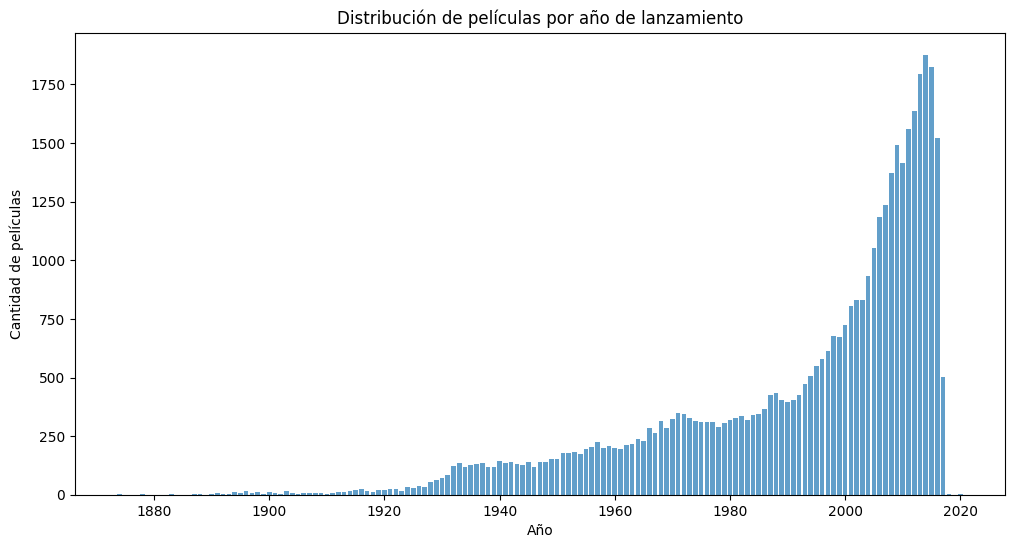

In [19]:
import matplotlib.pyplot as plt

# Agrupar por año y contar la cantidad de películas
peliculas_por_anio = movies['release_year'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(12, 6))  # Aumentar el tamaño de la figura
plt.bar(peliculas_por_anio.index, peliculas_por_anio.values, width=0.8, alpha=0.7)

# Configurar etiquetas
plt.title("Distribución de películas por año de lanzamiento")
plt.xlabel("Año")
plt.ylabel("Cantidad de películas")

# Mostrar el gráfico
plt.show()


**Conclusión sobre el año de lanzamiento**: si bien existen películas en los datasets que fueron estrenadas antes de 1900, a partir del '30 comenzó lentamente a aumentar este número con una explosión después del 2000.

## Análisis de la popularidad de las películas

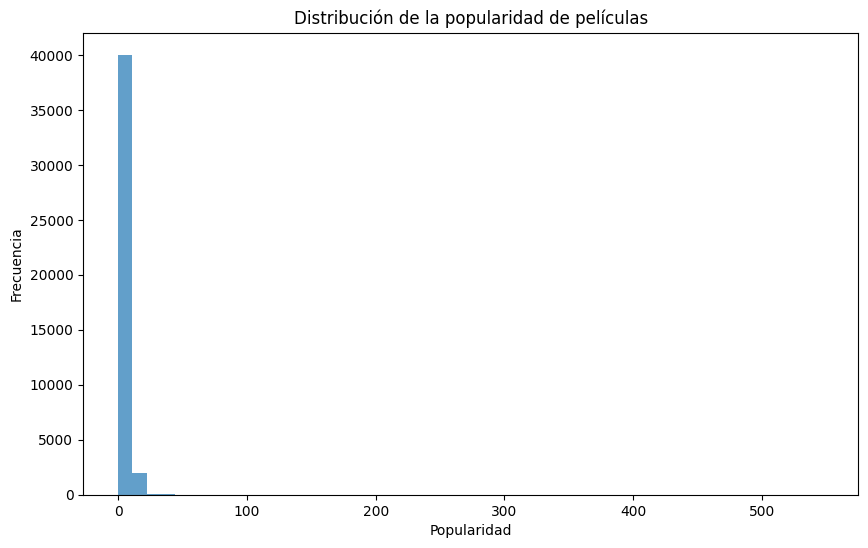

In [20]:
movies['popularity'] = movies['popularity'].astype(float)


plt.figure(figsize=(10, 6))
movies['popularity'].plot(kind='hist', bins=50, alpha=0.7)
plt.title("Distribución de la popularidad de películas")
plt.xlabel("Popularidad")
plt.ylabel("Frecuencia")
plt.show()


In [21]:
print("Top 5 películas más populares:")
print(movies[['title', 'popularity']].sort_values(by='popularity', ascending=False).head(5))


Top 5 películas más populares:
                                title  popularity
30700                         Minions  547.488298
43644                     Baby Driver  228.032744
24455                      Big Hero 6  213.849907
26564                        Deadpool  187.860492
26566  Guardians of the Galaxy Vol. 2  185.330992


**Conclusión de la popularidad:** La mayoría de las peliculas tienen un cero en popularidad, pero hay algunas muy taquilleras que llegan a tener una popularidad mayor a 150.

## Análisis de la filmación de películas por parte de los directores

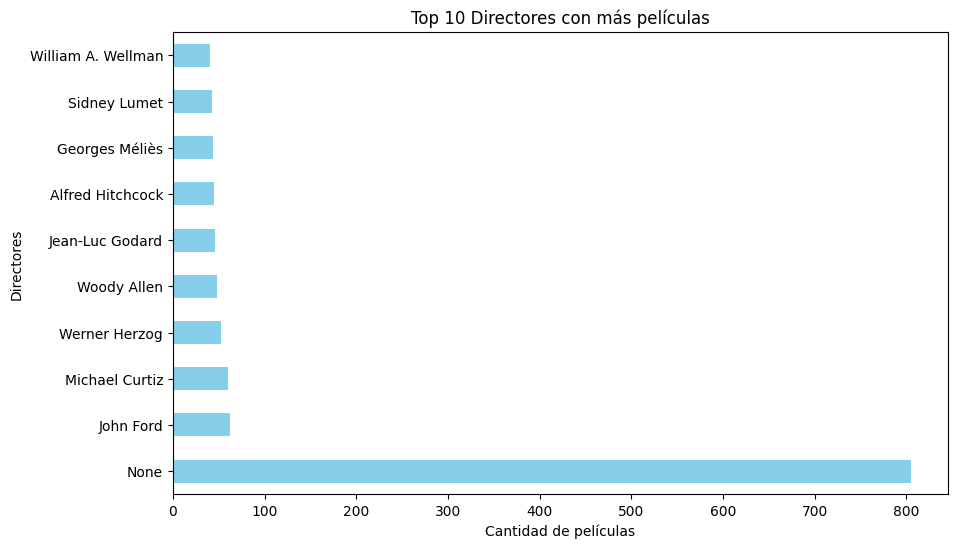

In [22]:
top_directors = credits['director_name'].value_counts().head(10)
top_directors.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title("Top 10 Directores con más películas")
plt.xlabel("Cantidad de películas")
plt.ylabel("Directores")
plt.show()

In [28]:
credits['director_name'].value_counts()

director_name
None                  805
John Ford              62
Michael Curtiz         60
Werner Herzog          53
Woody Allen            48
                     ... 
Todd Grimes             1
Pat Healy               1
Konkona Sen Sharma      1
Anshai Lal              1
Sergey Chekalov         1
Name: count, Length: 16842, dtype: int64

In [42]:
credits['director_name'].value_counts().head(7000)

director_name
None                   805
John Ford               62
Michael Curtiz          60
Werner Herzog           53
Woody Allen             48
                      ... 
Brian Miller             1
Carl Lindbergh           1
Jack Lewis               1
Kazuhisa Takenouchi      1
Chuck Patton             1
Name: count, Length: 7000, dtype: int64

**Conclusión sobre los directores:**

- El dataset incluye 805 películas que no tienen registrado el nombre del director. Estas películas se mantienen en el dataset para preservar la información restante, ya que la ausencia del director solo afecta a la funcionalidad de la función `get_director`.
- Se identificaron un total de 16,842 directores responsables de aproximadamente 42,000 películas. Sin embargo, menos de la mitad de estos directores han filmado más de dos películas. Esto significa que más de la mitad de los directores en el dataset han dirigido únicamente una película, lo que refleja una alta proporción de directores con una participación limitada en el dataset.